In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")


In [9]:
!pip install kagglehub



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/white-blood-cells-dataset")
print("Path to dataset files:", path)

np.random.seed(42)
tf.random.set_seed(42)
print("Setting up the dataset path...")
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

dataset_base_path = path
train_path = os.path.join(dataset_base_path, "Train")
test_path = os.path.join(dataset_base_path, "Test-A")
classes = ["Neutrophil", "Lymphocyte", "Monocyte", "Eosinophil", "Basophil"]


print("Loading and preprocessing images...")

Resuming download from 414187520 bytes (109424577 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/masoudnickparvar/white-blood-cells-dataset?dataset_version_number=1 (414187520/523612097) bytes left.


100%|███████████████████████████████████████████████████████████████████████████████| 499M/499M [01:19<00:00, 1.38MB/s]

Extracting files...


Path to dataset files: C:\Users\HP\.cache\kagglehub\datasets\masoudnickparvar\white-blood-cells-dataset\versions\1
Setting up the dataset path...
Loading and preprocessing images...


In [11]:
def load_images_from_directory(directory_path, classes):
    images = []
    labels = []
    image_paths = []
    img_size = 128

    for label_idx, class_name in enumerate(classes):
        class_path = os.path.join(directory_path, class_name)

        if not os.path.exists(class_path):
            print(f"Warning: Path {class_path} does not exist")
            continue

        for img_file in tqdm(os.listdir(class_path), desc=f"Loading {class_name}"):
            img_path = os.path.join(class_path, img_file)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize((img_size, img_size))
                images.append(np.array(img))
                labels.append(label_idx)
                image_paths.append(img_path)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels), image_paths

In [12]:
X_train_data, y_train_data, train_image_paths = load_images_from_directory(train_path, classes)
print(f"Loaded {len(X_train_data)} training images")

X_test_data, y_test_data, test_image_paths = load_images_from_directory(test_path, classes)
print(f"Loaded {len(X_test_data)} test images")

Loading Neutrophil:   0%|          | 0/6231 [00:00<?, ?it/s]

Loading Lymphocyte:   0%|          | 0/2427 [00:00<?, ?it/s]

Loading Monocyte:   0%|          | 0/561 [00:00<?, ?it/s]

Loading Eosinophil:   0%|          | 0/744 [00:00<?, ?it/s]

Loading Basophil:   0%|          | 0/212 [00:00<?, ?it/s]

Loaded 10175 training images


Loading Neutrophil:   0%|          | 0/2660 [00:00<?, ?it/s]

Loading Lymphocyte:   0%|          | 0/1034 [00:00<?, ?it/s]

Loading Monocyte:   0%|          | 0/234 [00:00<?, ?it/s]

Loading Eosinophil:   0%|          | 0/322 [00:00<?, ?it/s]

Loading Basophil:   0%|          | 0/89 [00:00<?, ?it/s]

Loaded 4339 test images



Data Exploration:
Neutrophil: 6231 training images
Lymphocyte: 2427 training images
Monocyte: 561 training images
Eosinophil: 744 training images
Basophil: 212 training images


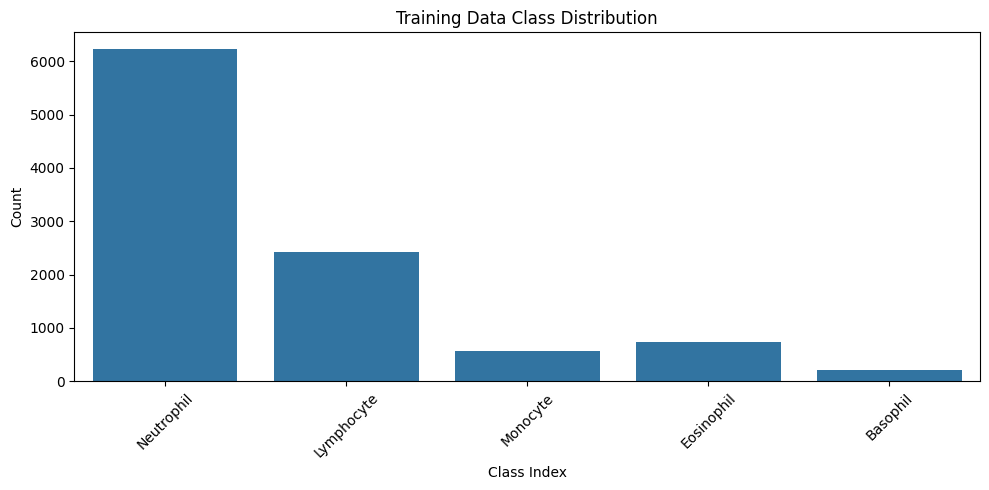

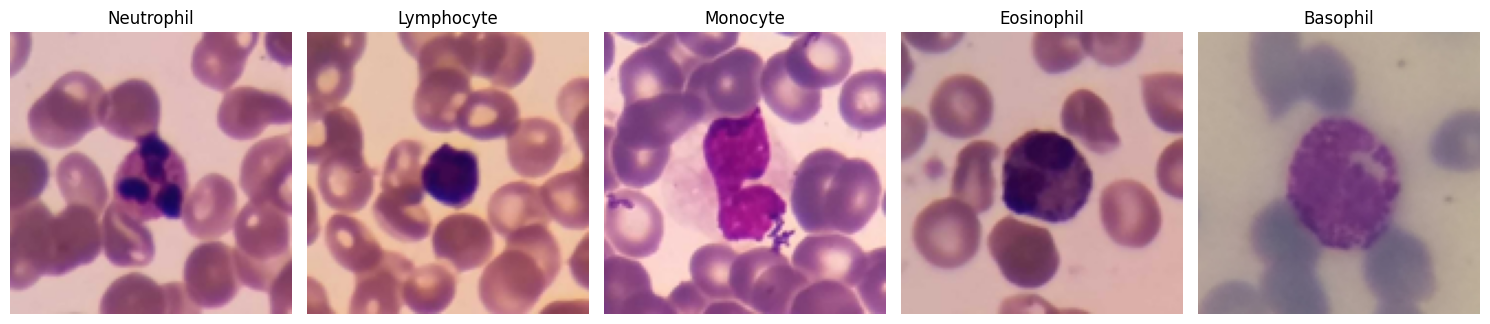

In [13]:
print("\nData Exploration:")

train_class_counts = np.bincount(y_train_data)
for i, count in enumerate(train_class_counts):
    if i < len(classes):
        print(f"{classes[i]}: {count} training images")


plt.figure(figsize=(10, 5))
sns.countplot(x=y_train_data)
plt.title('Training Data Class Distribution')
plt.xlabel('Class Index')
plt.xticks(range(len(classes)), classes, rotation=45)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes):
    if i < len(classes):
        class_indices = np.where(y_train_data == i)[0]
        if len(class_indices) > 0:
            sample_idx = class_indices[0]
            plt.subplot(1, len(classes), i+1)
            plt.imshow(X_train_data[sample_idx])
            plt.title(class_name)
            plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:

print("\nPreparing data for training...")


X_train = X_train_data / 255.0
X_test = X_test_data / 255.0


y_train = tf.keras.utils.to_categorical(y_train_data, len(classes))
y_test = tf.keras.utils.to_categorical(y_test_data, len(classes))


X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")


Preparing data for training...
Training set: 8140 images
Validation set: 2035 images
Test set: 4339 images



Setting up data augmentation...


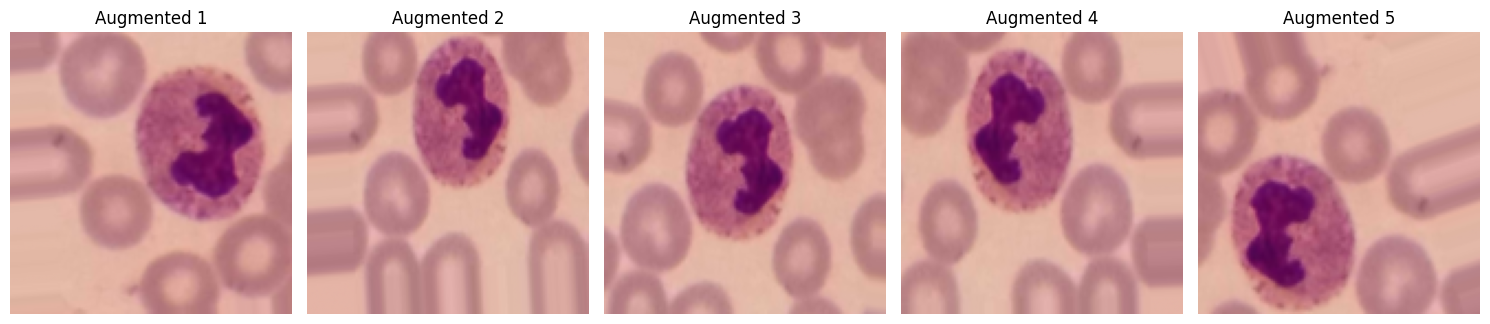

In [15]:
print("\nSetting up data augmentation...")

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    augmented = datagen.random_transform(X_train[0])
    plt.imshow(augmented)
    plt.title(f'Augmented {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
print("\nBuilding high accuracy CNN model...")

img_size = 128

def build_optimized_cnn():
    model = Sequential([

        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 3)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),


        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),


        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),


        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),

        Flatten(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(classes), activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


cnn_model = build_optimized_cnn()
cnn_model.summary()

callbacks = [
    ModelCheckpoint('best_wbc_model.keras', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]


Building high accuracy CNN model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 38,778,181 (147.93 MB)

 Trainable params: 38,773,189 (147.91 MB)

 Non-trainable params: 4,992 (19.50 KB)

In [17]:
print("\nTraining high accuracy CNN model...")

history = cnn_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)


Training high accuracy CNN model...
Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1606s 6s/step - accuracy: 0.5128 - loss: 1.5500 - val_accuracy: 0.2388 - val_loss: 15.6370 - learning_rate: 5.0000e-04
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1581s 6s/step - accuracy: 0.8208 - loss: 0.5368 - val_accuracy: 0.5838 - val_loss: 3.1150 - learning_rate: 5.0000e-04
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1588s 6s/step - accuracy: 0.8699 - loss: 0.3930 - val_accuracy: 0.2619 - val_loss: 5.7390 - learning_rate: 5.0000e-04
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1576s 6s/step - accuracy: 0.8851 - loss: 0.3356 - val_accuracy: 0.8241 - val_loss: 0.5567 - learning_rate: 5.0000e-04
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2106s 8s/step - accuracy: 0.8975 - loss: 0.3091 - val_accuracy: 0.7459 - val_loss: 0.7322 - learning_rate: 5.0000e-04
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1602s 6s/step - accuracy: 0.9130 - loss: 0.2617 - val_accuracy: 0.5287 - val_loss: 2.6425 - learning_rate: 5.0000e-04
Epoch 7/10
255

In [18]:
print("\nEvaluating model on test set...")


test_loss, test_acc = cnn_model.evaluate(X_test, y_test, verbose=1)
print(f"CNN Model - Test Accuracy: {test_acc:.4f}")



Evaluating model on test set...
136/136 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9558 - loss: 0.1417
CNN Model - Test Accuracy: 0.9558


In [19]:
print(f"\nGenerating detailed metrics for the model...")

y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)



Generating detailed metrics for the model...
136/136 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step



Classification Report:
              precision    recall  f1-score   support

  Neutrophil       0.97      0.98      0.98      2660
  Lymphocyte       0.98      0.95      0.96      1034
    Monocyte       0.84      0.74      0.79       234
  Eosinophil       0.83      0.92      0.88       322
    Basophil       0.98      0.93      0.95        89

    accuracy                           0.96      4339
   macro avg       0.92      0.91      0.91      4339
weighted avg       0.96      0.96      0.96      4339



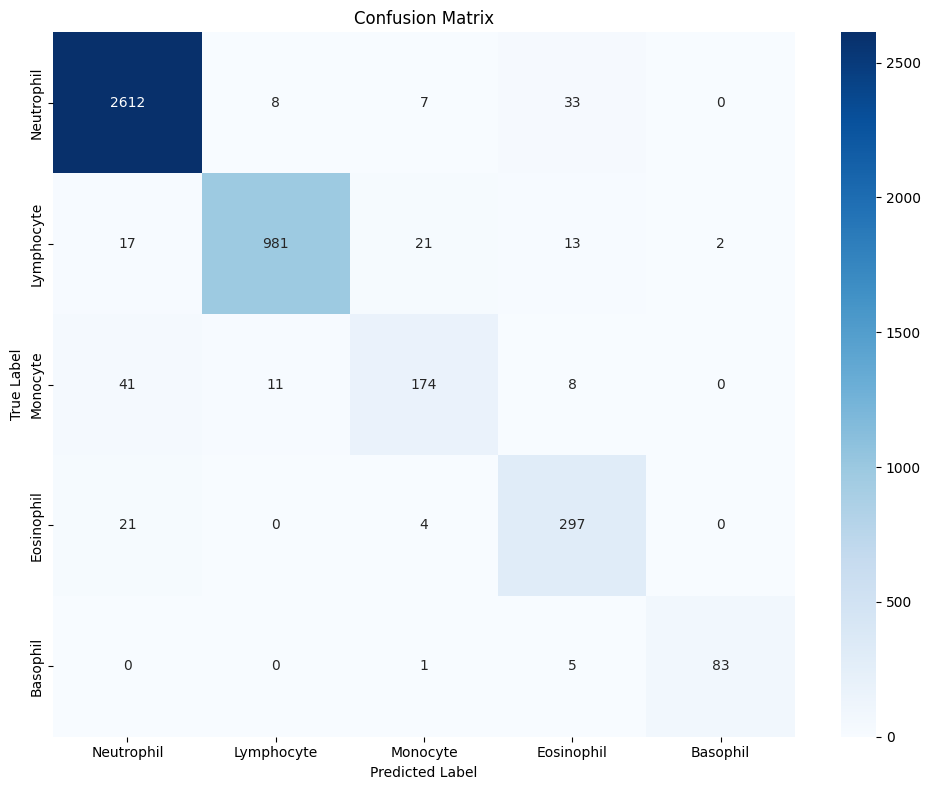

In [20]:
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=classes))


plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()



Visualizing training history...


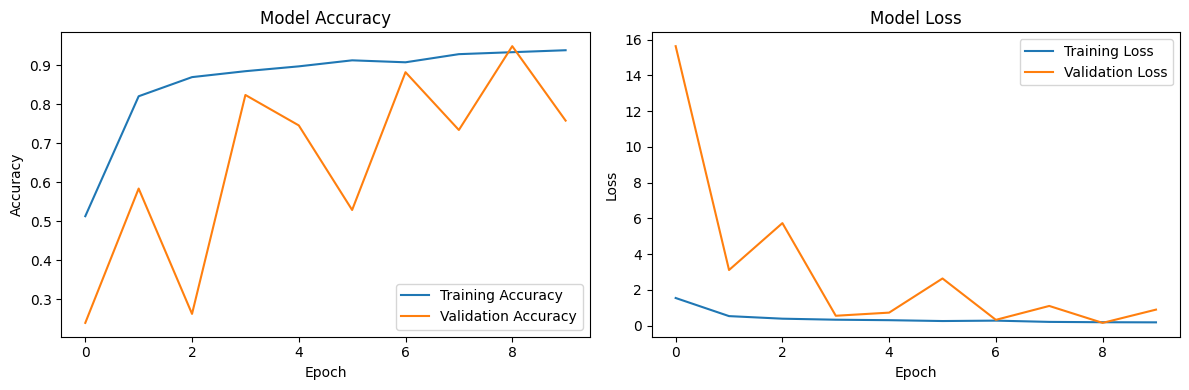

In [21]:
print("\nVisualizing training history...")

plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Visualizing model predictions...


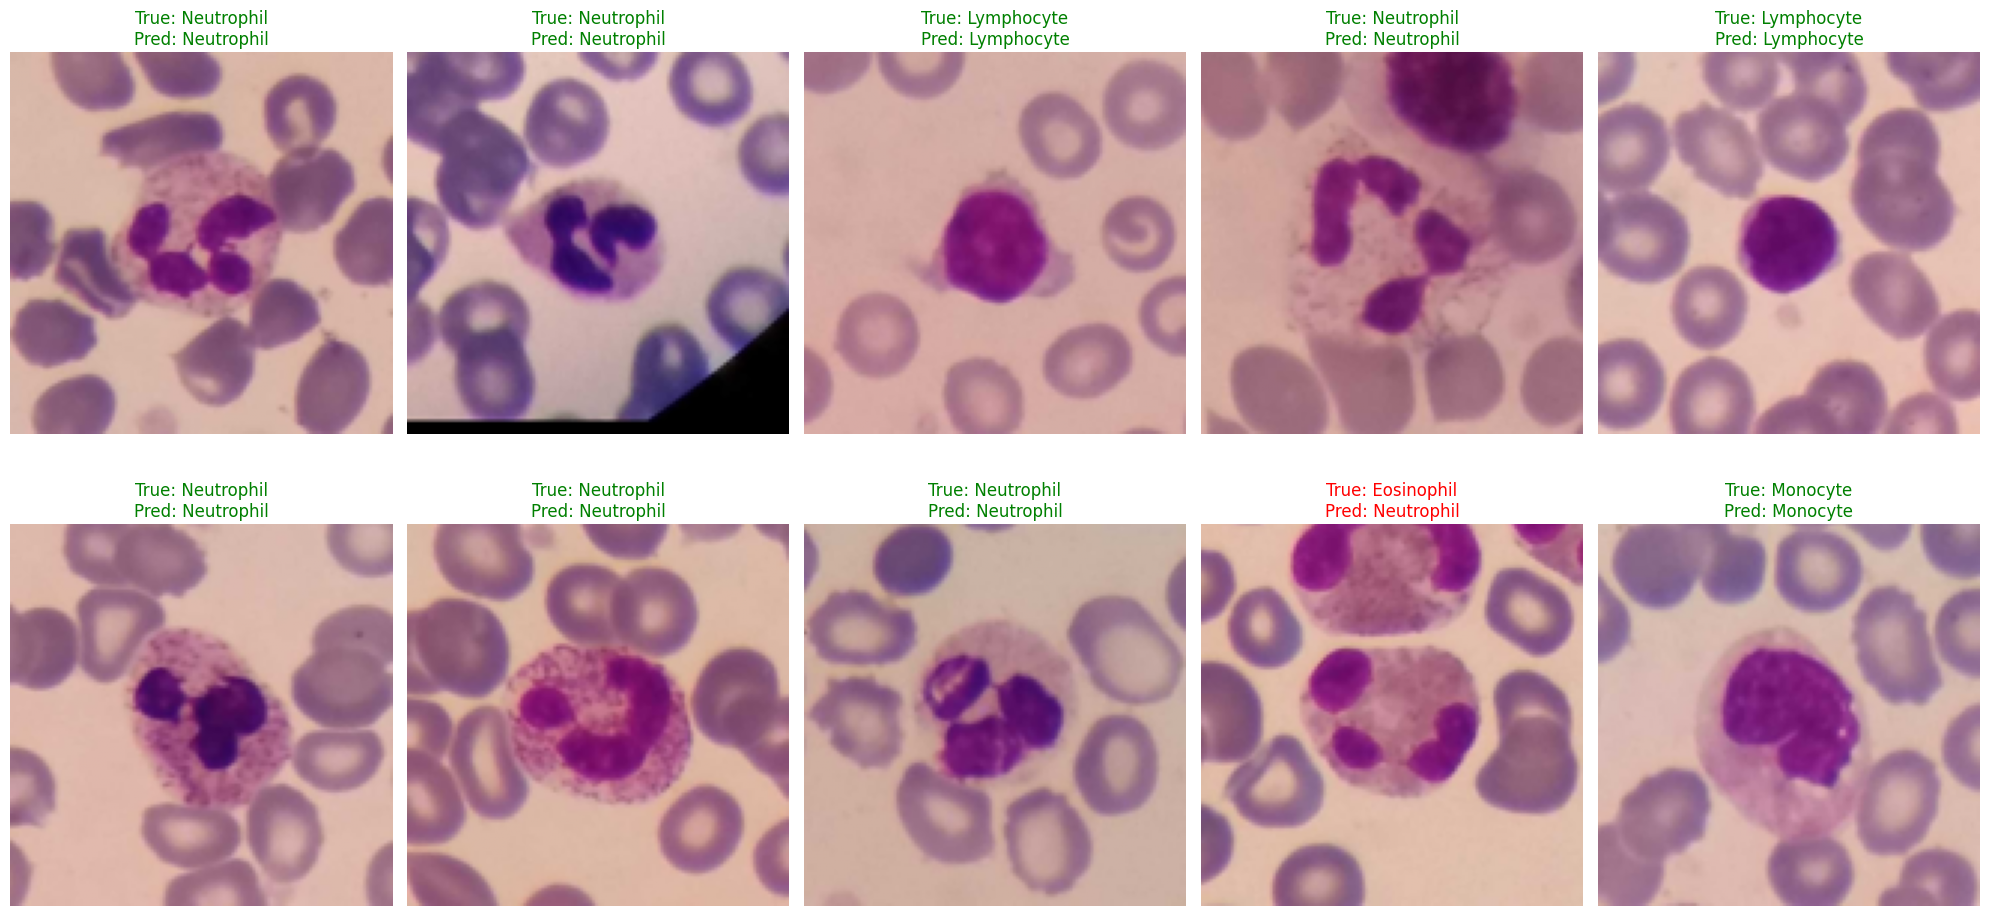

In [22]:
print("\nVisualizing model predictions...")


indices = np.random.choice(range(len(X_test)), size=10, replace=False)

plt.figure(figsize=(20, 10))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {classes[y_true_classes[idx]]}\nPred: {classes[y_pred_classes[idx]]}",
              color=('green' if y_true_classes[idx] == y_pred_classes[idx] else 'red'))
    plt.axis('off')
plt.tight_layout()
plt.show()

cnn_model.save('wbc_classification_model.keras')


Model saved as 'wbc_classification_model.keras'

Sample prediction demonstration:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Predicted class: Neutrophil with 99.92% confidence


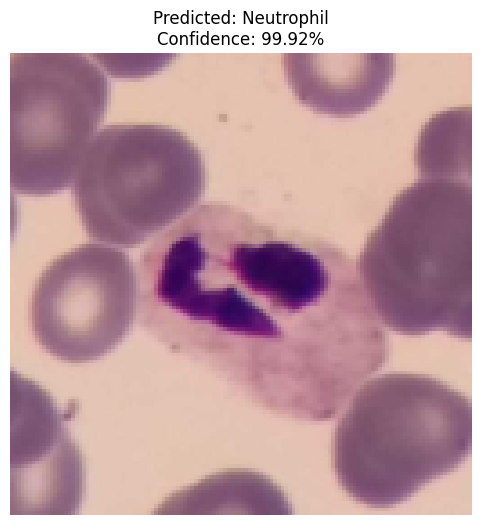

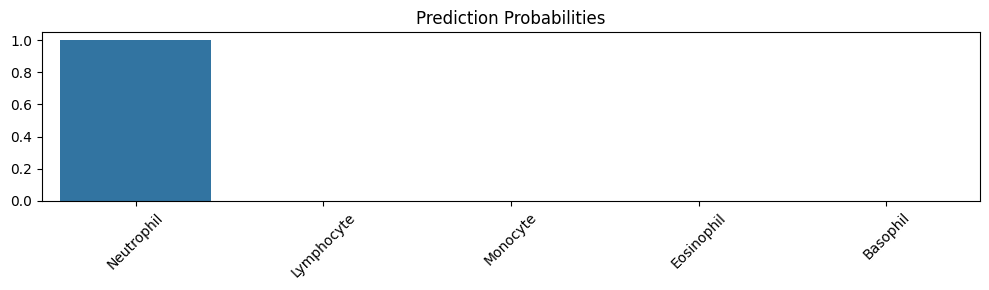


Project completed successfully!


In [23]:
print("\nModel saved as 'wbc_classification_model.keras'")


def predict_wbc_image(image_path, model=cnn_model):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((img_size, img_size))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    pred_class = np.argmax(prediction, axis=1)[0]

    print(f"Predicted class: {classes[pred_class]} with {prediction[0][pred_class]:.2%} confidence")


    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {classes[pred_class]}\nConfidence: {prediction[0][pred_class]:.2%}")
    plt.axis('off')
    plt.show()


    plt.figure(figsize=(10, 3))
    sns.barplot(x=classes, y=prediction[0])
    plt.title('Prediction Probabilities')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return classes[pred_class], prediction[0]


if len(test_image_paths) > 0:
    sample_idx = np.random.choice(range(len(test_image_paths)))
    print(f"\nSample prediction demonstration:")
    predict_wbc_image(test_image_paths[sample_idx])
    
print("\nProject completed successfully!")